# <center> Introduction to Topological Data Analysis with Python</center>

### <center> Sarah Percival </center>
<center> Department of Mathematics and Statistics, University of New Mexico</center>

# Welcome
This notebook is for MA 532. We introduce the Euler Characteristic Transform. Email spercival@unm.edu with questions or comments.

# Goals
* Go over Python basics
* Use Python to visualize the Euler characteristic transform
* Apply the ECT to protein data

# The big picture

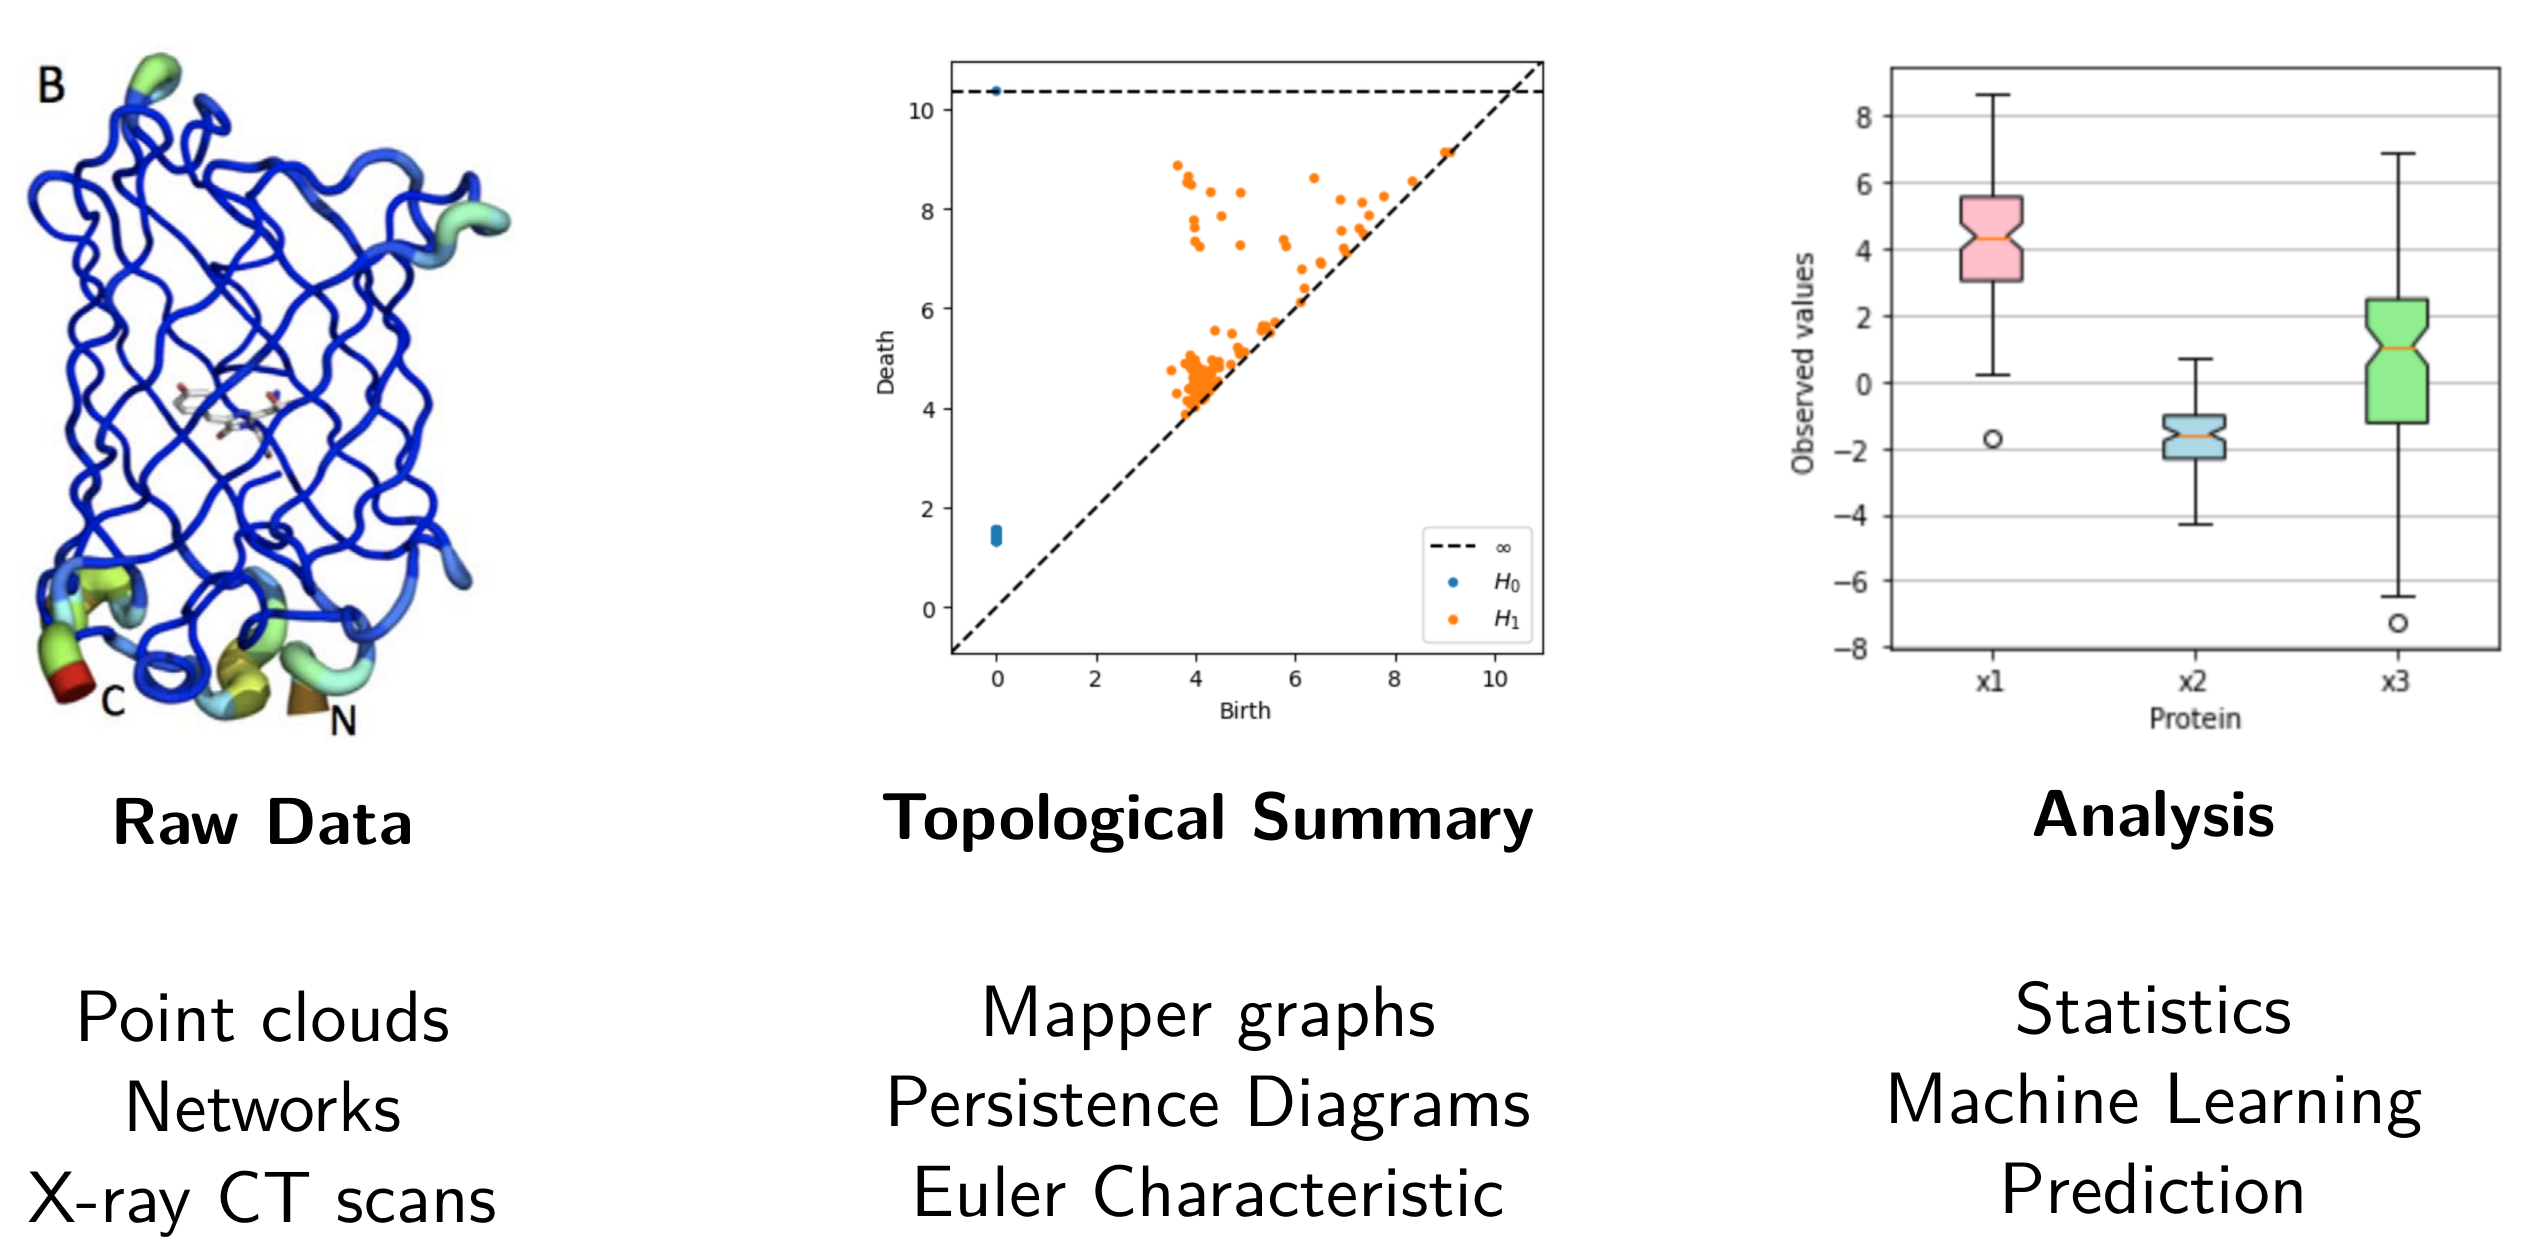

# Euler Characteristic Transform

Persistent homology is computationally expensive. This means that the calculations required to compute it are complex and take a long time. If we want to analyze 200 million proteins, we may need something that is more simple computationally. That's where the Euler Characteristic Transform, or ECT, comes in.

Let's look at how the ECT works on some toy data. Here, we have an example of an $\alpha$-helix

In [1]:
# import packages
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# generate toy data that looks like a helix
u = np.linspace(0,10*np.pi,1000)
x=2.5*np.cos(u)
y=2.5*np.sin(u)
z=(u/np.pi)

helix = np.column_stack([x,y,z])

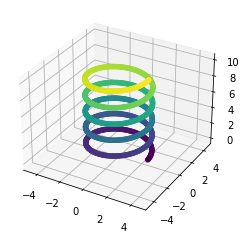

In [3]:
# Create the figure
fig4 = plt.figure()

# Add an axes
ax = fig4.add_subplot(111,projection='3d')

plt.xlim(-5,5)
plt.ylim(-5,5)

# and plot the point 
ax.scatter(x , y, z, c=z, alpha = 1)

The ECT works as follows:
1) Select a direction

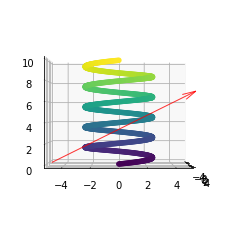

In [4]:
# Create the figure
fig4 = plt.figure()

# Add an axes
ax = fig4.add_subplot(111,projection='3d');

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(0,10)

# set viewing angle
ax.view_init(azim=0, elev=0)

ax.quiver(0, -5, 0, # <-- starting point of vector
    3.5, 10.5, 7, # <-- directions of vector
    color = 'red', alpha = .8, lw = 1, arrow_length_ratio=0.08)

# and plot the point 
ax.scatter(x , y, z, c=z, alpha = 1)

2) Sweep a plane along the chosen direction, only looking at points below the plane. We need to decide a number of time points to look at. Let's choose 100, because it's enough that we can sweep the plane smoothly, but small enough to be computationally feasible.

![angle_ECT_combined.gif](https://github.com/sperciva/Backups/blob/main/Tutorial/ECT_angle_combined.gif?raw=true)

3) Make note of how many connected components are present at each given timestamp. We do this by applying a clustering algorithm and counting how many clusters there are.

In [5]:
from sklearn.cluster import DBSCAN

In [6]:
def compute_ecc(data, end_time, starting_point, normal, epsilon):
    """Computes the Euler characteristic curve along a given direction.

    Direction is given by normal vector. Begin by computing the dot product of the normal vector with the starting
    point. Incrementally increase starting vector to sweep along normal.
    
    A plane is given by the equation a*x+b*y+c*z+d=0 where [a,b,c] is the normal. Thus, we have to calculate d to
    find all points such that a*x+b*y+c*z+d<0

    Parameters
    ----------
    data : array-like

        Input point cloud
        
    end_time : scalar
    
        Start time is assumed to be 0. End time is the maximum value that the starting point is multiplied by.
        
    starting_point: array-like
    
        This is the center of the first plane
        
    normal: array-like
    
        The direction along which to sweep the plane
        
    epsilon: scalar
    
        The epsilon parameter for DBSCAN. Dependent on the data, generally related to molecular bond length.

    Returns
    -------
    connected_components : list

        For each timestamp, return the number of connected components below the plane at that time.
    """

    connected_components = []

    for i in np.linspace(0,end_time,100):
        point  = i*normal+starting_point

        d = -point.dot(normal)

        sublevel_pts = data[data.dot(normal) + d < 0]

        try:
            clustering = DBSCAN(eps=epsilon, min_samples=2).fit(sublevel_pts)
            connected_components.append(len(set(clustering.labels_)))
        except: # if there are no points below the plane, there will be an error, so say 0 ccs in this case.
            connected_components.append(0)
            
    return connected_components

In [7]:
angle_ecc = compute_ecc(helix, 3.5, np.array([0,-5,0]), np.array([0,3,2]), 0.1)

4) Repeat steps 1-3. The more angles we choose, the better an idea of the shape we get.

![vertical_ECT_combined.gif](https://github.com/sperciva/Backups/blob/main/Tutorial/ECT_vertical_combined.gif?raw=true)

In [8]:
vertical_ecc = compute_ecc(helix, 10, np.array([0,0,0]), np.array([0,0,1]), 0.1)

5) The output of step 3 is a vector recording the number of connected components at each discrete time stamp. Concatenate the vectors generated from the different angles. The resulting vector is the Euler Characteristic Transform.

The ECT can also be represented as a picture. Here is an image showing the computation of an ECC for a fern leaf, then the ECT in image form.

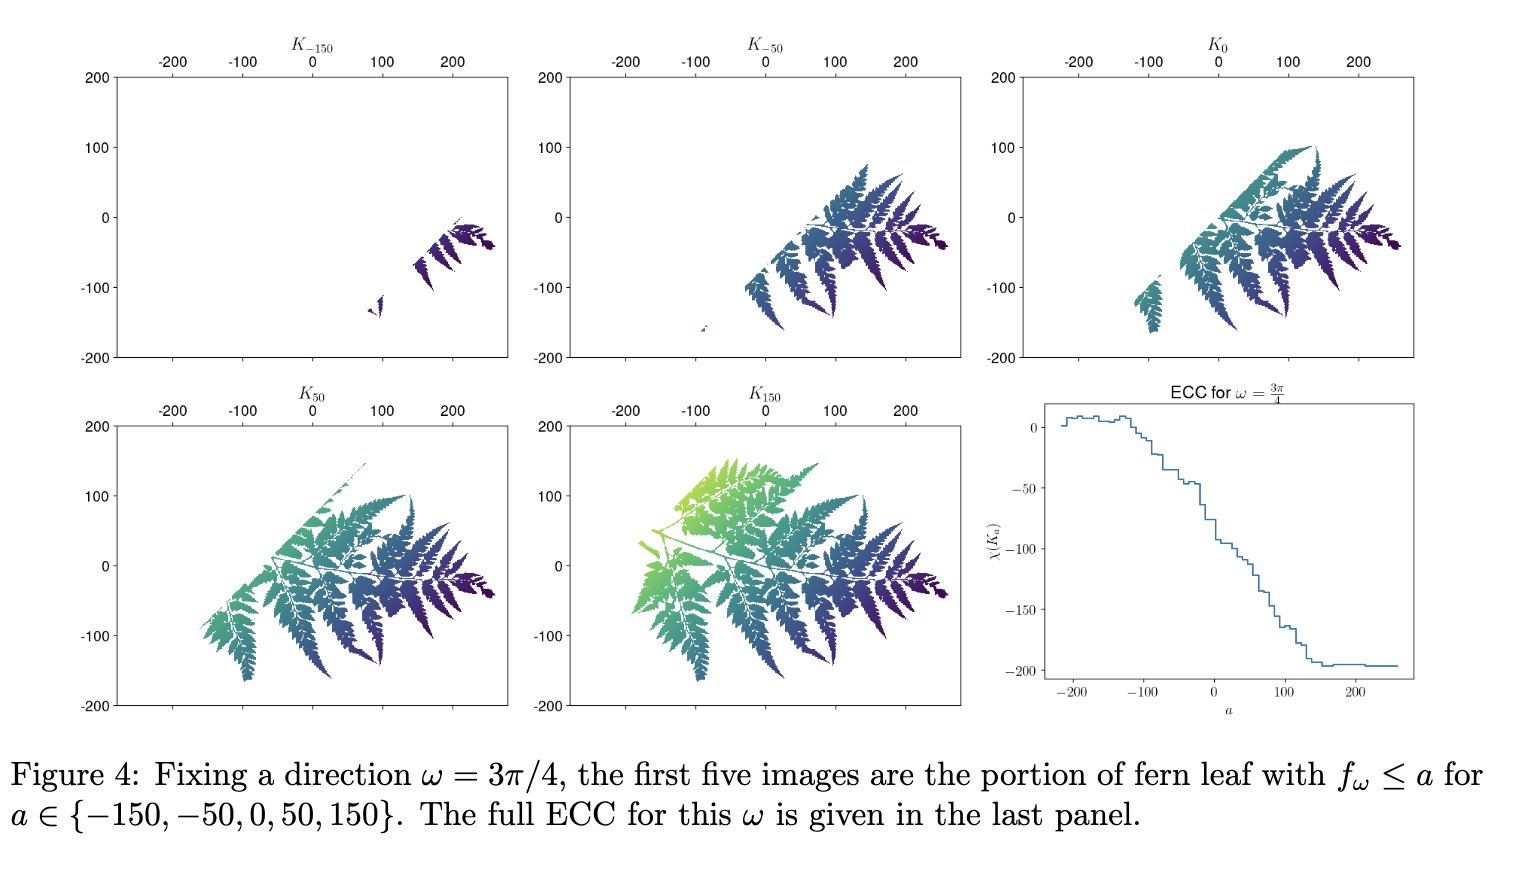

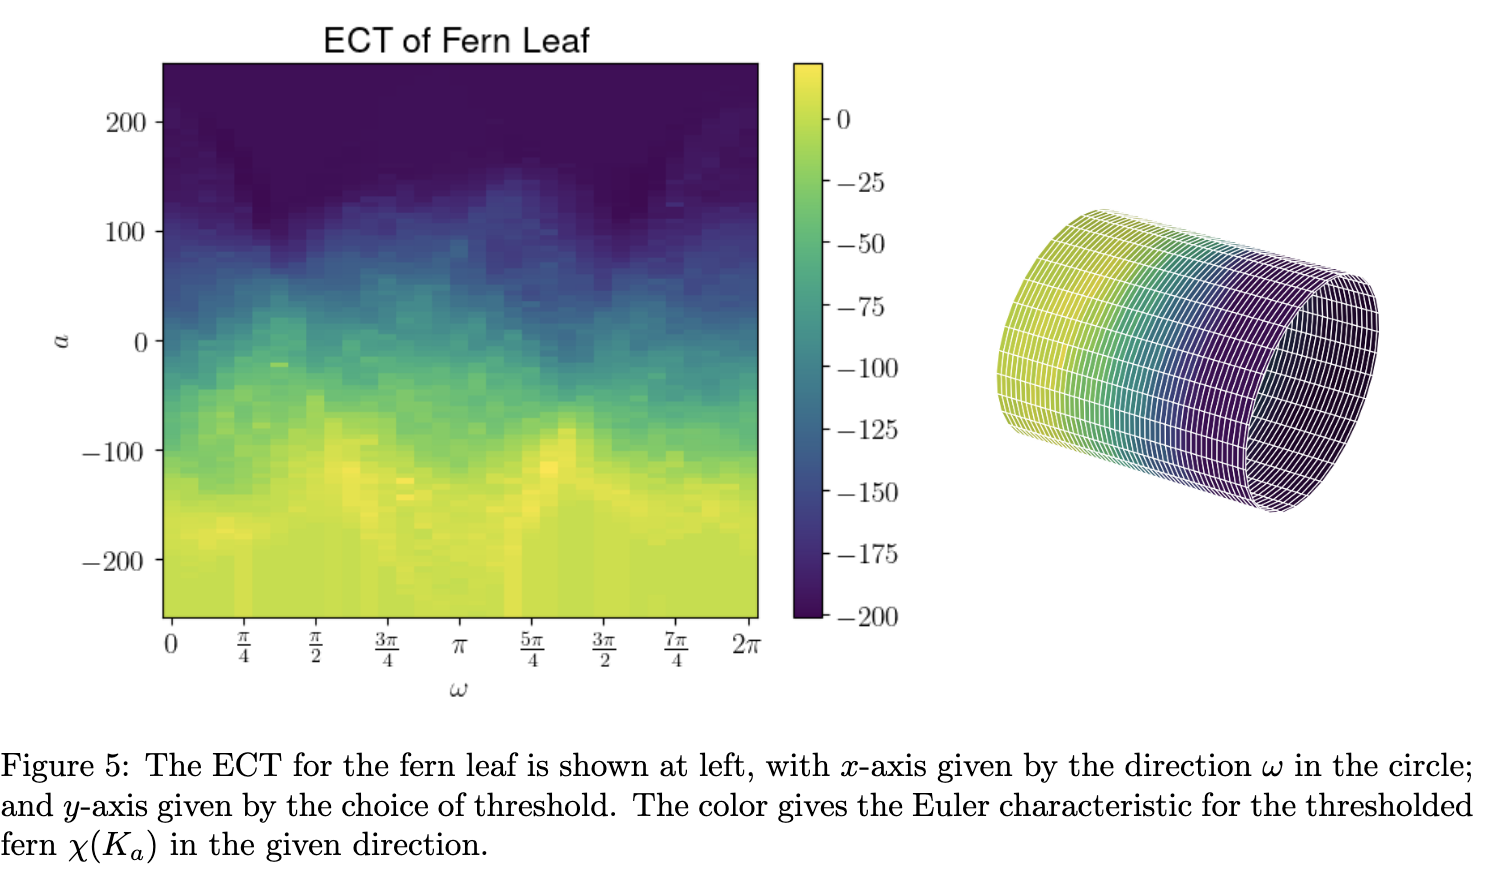

Both pictures are from the paper "An Invitation to the Euler Characteristic Transform" by Elizabeth Munch.

# Our data

Our data in this lecture is a protein molecule called the green fluorescent protein, pictured above. The dataset consists of a set of points in $\mathbb{R}^3$ with each point corresponding to an atom in the molecule.

In [9]:
import pandas as pd

protein = pd.read_csv("AF-W6KDG8-F1-model_v3.pdb", delim_whitespace = True, header = None)

We want to examine the backbone of the protein, which provides its main structure.

In [10]:
# select the entire backbone
CA_backbone = protein[protein[2].isin(['N','C','CA'])]

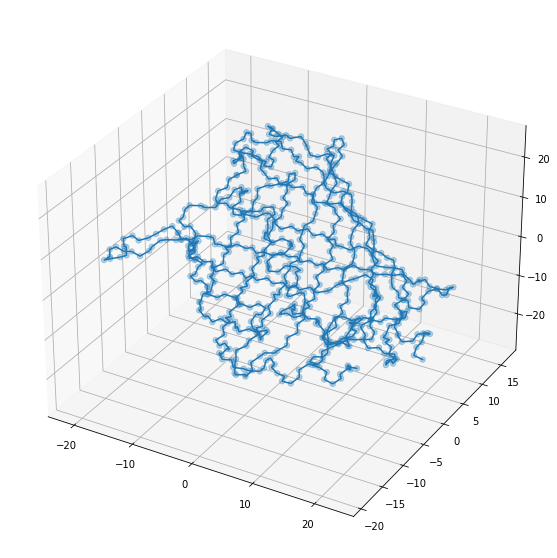

In [11]:
import matplotlib.pyplot as plt

# the atoms are in order in the PDB files, so we connect adjacent atoms
fig1 = plt.figure(figsize=(10,10))
ax = fig1.add_subplot(projection='3d')

ax.scatter(CA_backbone[6].tolist(), CA_backbone[7].tolist(), CA_backbone[8].tolist(), s=30, alpha=0.3)
ax.plot3D(CA_backbone[6].tolist(), CA_backbone[7].tolist(), CA_backbone[8].tolist())

plt.show()

Now it's time to apply the ECT to our data! Let's look at the GFP backbone again.

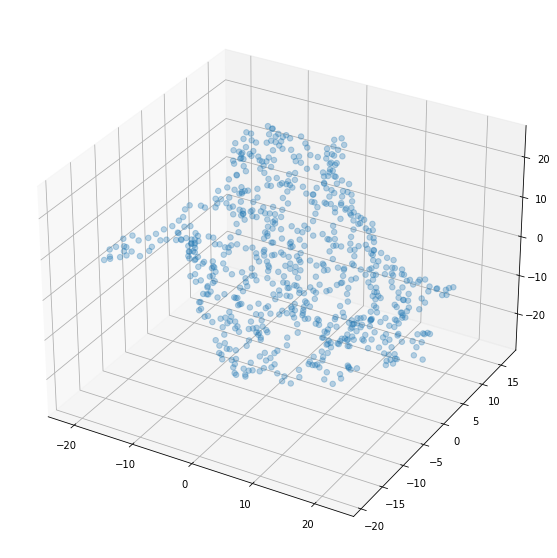

In [12]:
fig1 = plt.figure(figsize=(10,10))
ax = fig1.add_subplot(projection='3d')

ax.scatter(CA_backbone[6].tolist(), CA_backbone[7].tolist(), CA_backbone[8].tolist(), s=30, alpha=0.3)

plt.show()

In [13]:
protein_ecc = compute_ecc(np.array(CA_backbone[[6,7,8]]), 55, np.array([0,0,-25]), np.array([0,0,1]), 1.56)

In [14]:
print(protein_ecc)

[2, 3, 3, 3, 3, 3, 2, 2, 3, 3, 3, 3, 4, 5, 6, 6, 6, 6, 6, 7, 5, 4, 5, 6, 8, 8, 7, 7, 7, 8, 7, 6, 6, 7, 8, 8, 11, 12, 8, 9, 9, 9, 8, 8, 8, 7, 7, 7, 7, 7, 8, 10, 8, 9, 8, 7, 7, 7, 9, 9, 8, 8, 8, 9, 9, 8, 7, 6, 6, 7, 5, 5, 6, 6, 7, 8, 6, 6, 4, 4, 4, 3, 4, 4, 4, 3, 4, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
